In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score

In [2]:
df = pd.read_csv("NEW Candidates Cleaned.csv")
pd.set_option('display.max_columns', None)
df.head(5)

,Unnamed: 0,geo_name,year,votes,vote_share,incumbent,winner,prob_democrat,prob_republican,pid_est,prob_male,prob_female,gender_est,prob_black,prob_white,prob_hispanic,prob_asian,prob_other,race_est,contributor.cfscore,percent_women,percent_white,percent_black,percent_hispanic,percent_asian_american,candidate_count,cpi_prevYear,unemployment_prevYear,pid_est_knn,gender_est_knn,race_est_knn
0,3244,Abilene,1996,3826.0,0.89,1.0,1,0.050000,0.950000,Republican,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,1.020000,0.502459,0.798016,0.080899,0.178764,0.101590,2,152.383333,5.6,1.000000,1.0,2.0
1,4719,Abilene,1996,451.0,0.11,0.0,0,0.573265,0.426735,Unknown,1.0,0.0,Male,0.03,0.97,0.0,0.0,0.0,Caucasian,-0.145909,0.502459,0.798016,0.080899,0.178764,0.101590,2,152.383333,5.6,0.417135,1.0,2.0
2,530,Akron,2003,26967.0,0.71,1.0,1,1.000000,0.000000,Democrat,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,-0.850000,0.520664,0.657211,0.293766,0.014515,0.022447,2,179.866667,5.8,0.000000,1.0,2.0
3,1480,Akron,2003,11171.0,0.29,0.0,0,0.000000,1.000000,Republican,1.0,0.0,Male,0.58,0.41,0.0,0.0,0.0,Black,0.550000,0.520664,0.657211,0.293766,0.014515,0.022447,2,179.866667,5.8,1.000000,1.0,1.0
4,419,Akron,2011,31674.0,0.70,1.0,1,1.000000,0.000000,Democrat,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,-0.362011,0.517043,0.619837,0.313499,0.022048,0.030919,2,218.076167,9.6,0.000000,1.0,2.0


# Should the Model Have the Incumbent Column?

### Base Model, Without Incumbent Column

In [3]:
categorical_features = ["pid_est", "gender_est", "race_est"]
numeric_features = ["candidate_count"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['pid_est', 'gender_est',
                                                   'race_est']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [6]:
Y_pred = pipeline.predict(X_test)

In [7]:
print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       681
           1       0.54      0.60      0.57       367

    accuracy                           0.68      1048
   macro avg       0.66      0.66      0.66      1048
weighted avg       0.69      0.68      0.69      1048



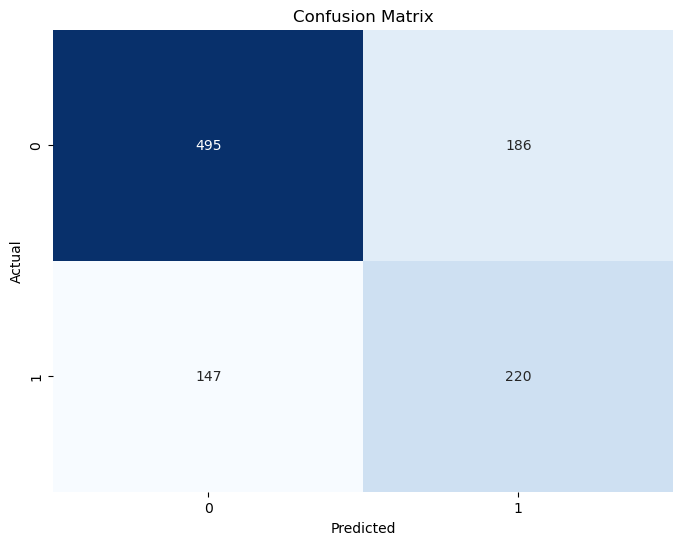

In [8]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

In [9]:
roc_auc = roc_auc_score(Y_test, Y_pred)
roc_auc

0.663163643783985

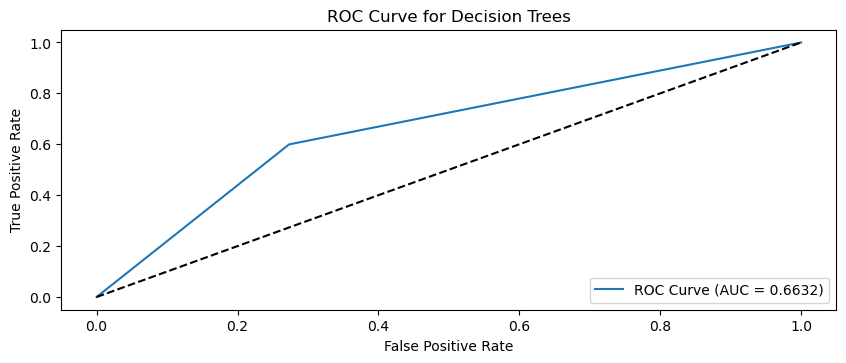

In [10]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Base Model, With Incumbent Column

In [11]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['pid_est', 'gender_est',
                                                   'race_est', 'incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [14]:
Y_pred = pipeline.predict(X_test)

In [15]:
print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       681
           1       0.77      0.77      0.77       367

    accuracy                           0.84      1048
   macro avg       0.83      0.83      0.83      1048
weighted avg       0.84      0.84      0.84      1048



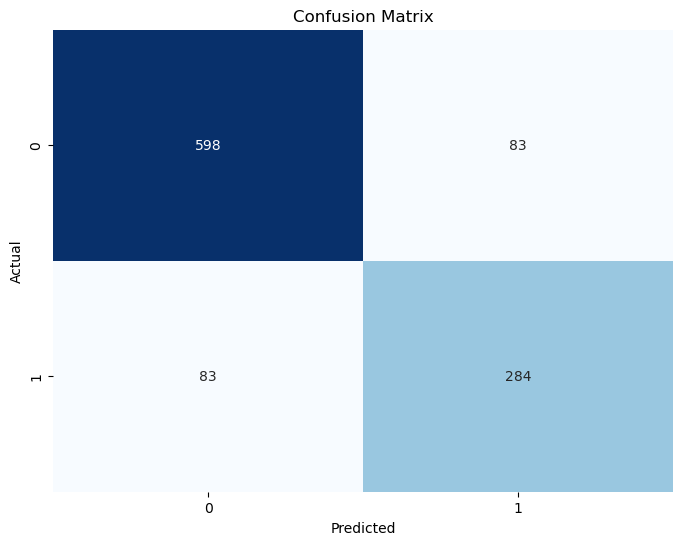

In [16]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

In [17]:
roc_auc = roc_auc_score(Y_test, Y_pred)
roc_auc

0.8259811865064598

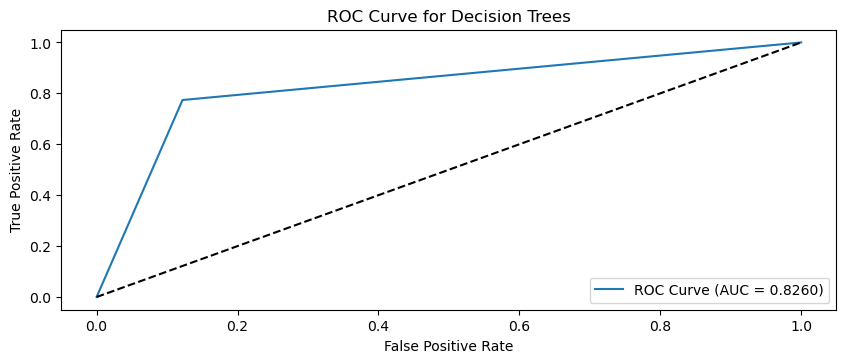

In [18]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

# Hyperparameter Tuning

### Varying Maximum Number of Features

In [19]:
model = DecisionTreeClassifier(max_features="sqrt", random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       681
           1       0.78      0.78      0.78       367

    accuracy                           0.84      1048
   macro avg       0.83      0.83      0.83      1048
weighted avg       0.84      0.84      0.84      1048



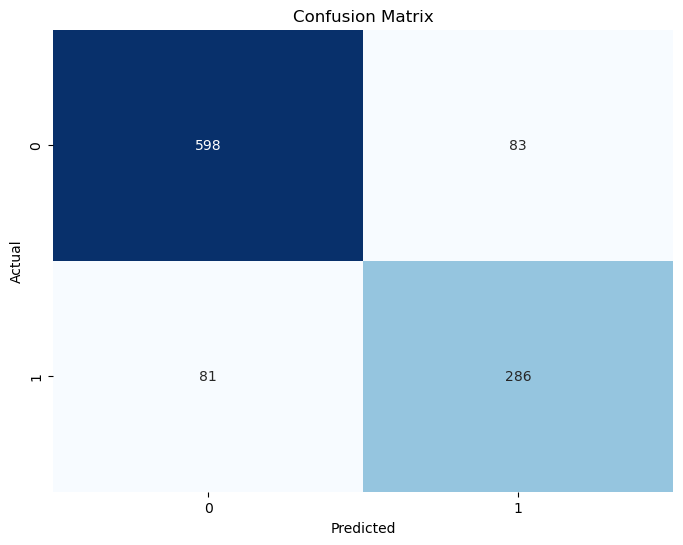

In [20]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

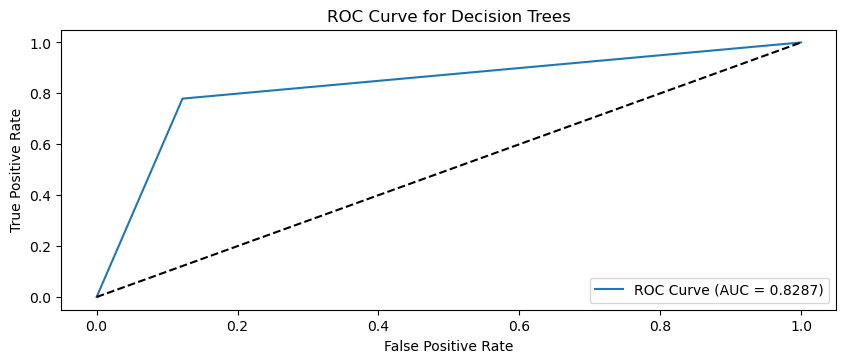

In [21]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Varying Minimum Leaf Node Size

In [22]:
model = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       681
           1       0.78      0.78      0.78       367

    accuracy                           0.85      1048
   macro avg       0.83      0.83      0.83      1048
weighted avg       0.85      0.85      0.85      1048



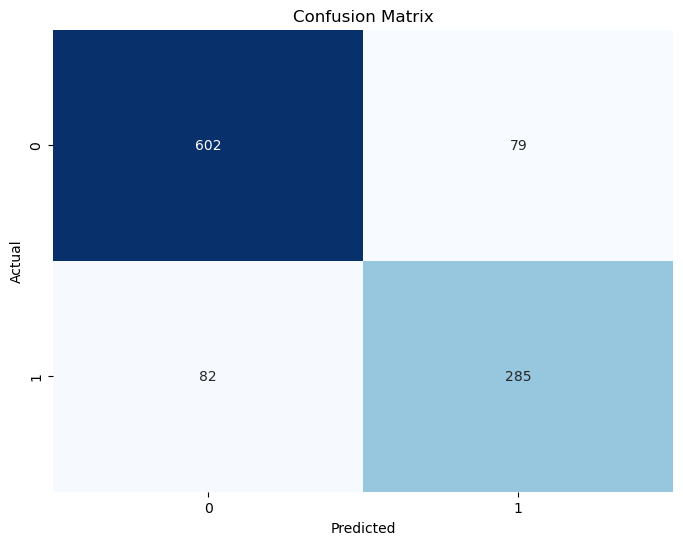

In [23]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

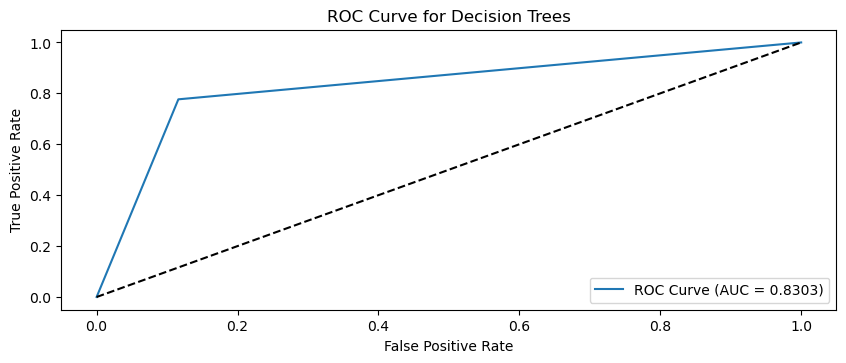

In [24]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

In [25]:
model = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       681
           1       0.78      0.79      0.78       367

    accuracy                           0.85      1048
   macro avg       0.83      0.83      0.83      1048
weighted avg       0.85      0.85      0.85      1048



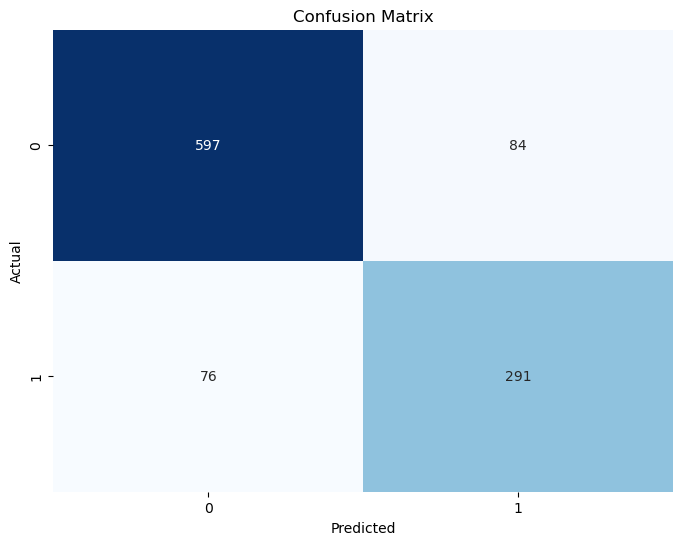

In [26]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

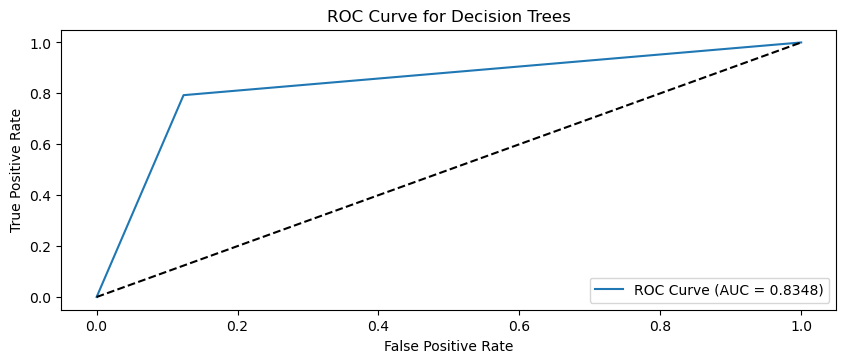

In [27]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Varying Maximum Tree Depth

In [28]:
model = DecisionTreeClassifier(max_depth=10, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       681
           1       0.77      0.78      0.77       367

    accuracy                           0.84      1048
   macro avg       0.82      0.83      0.83      1048
weighted avg       0.84      0.84      0.84      1048



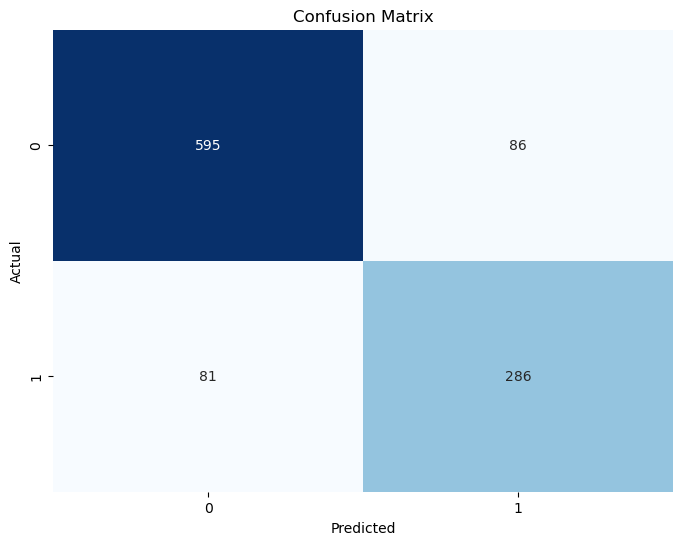

In [29]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

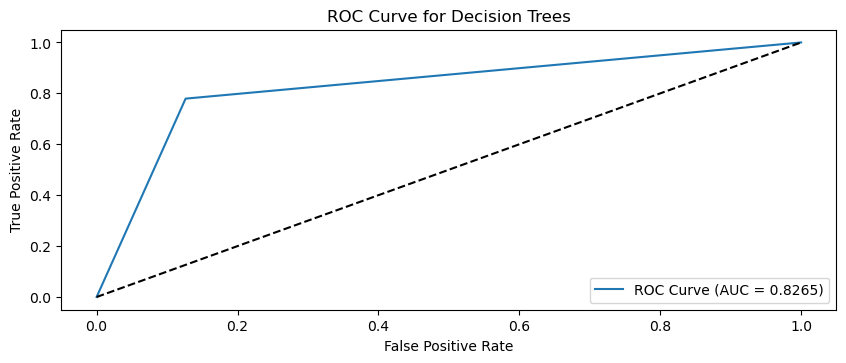

In [30]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

In [31]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       681
           1       0.78      0.79      0.79       367

    accuracy                           0.85      1048
   macro avg       0.83      0.84      0.83      1048
weighted avg       0.85      0.85      0.85      1048



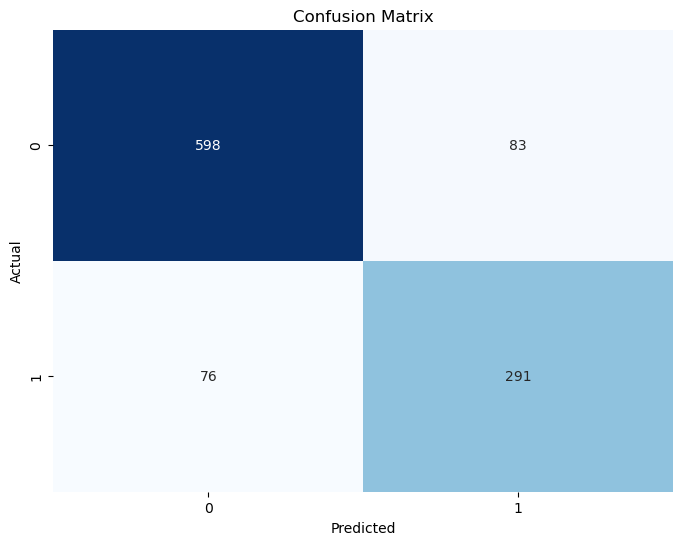

In [32]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

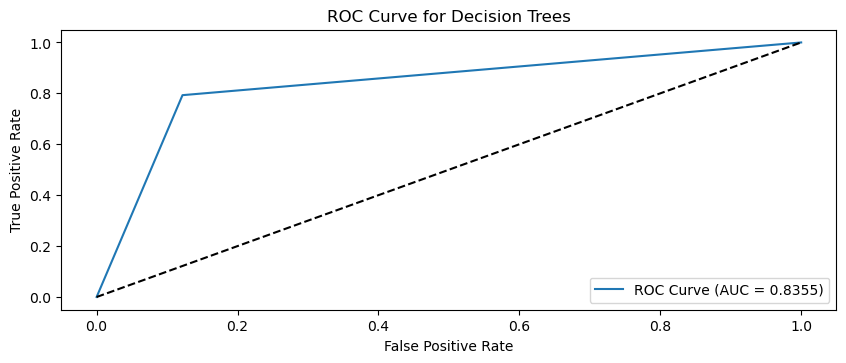

In [33]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Varying Split Criterion

In [34]:
model = DecisionTreeClassifier(criterion="entropy", random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       681
           1       0.77      0.77      0.77       367

    accuracy                           0.84      1048
   macro avg       0.83      0.83      0.83      1048
weighted avg       0.84      0.84      0.84      1048



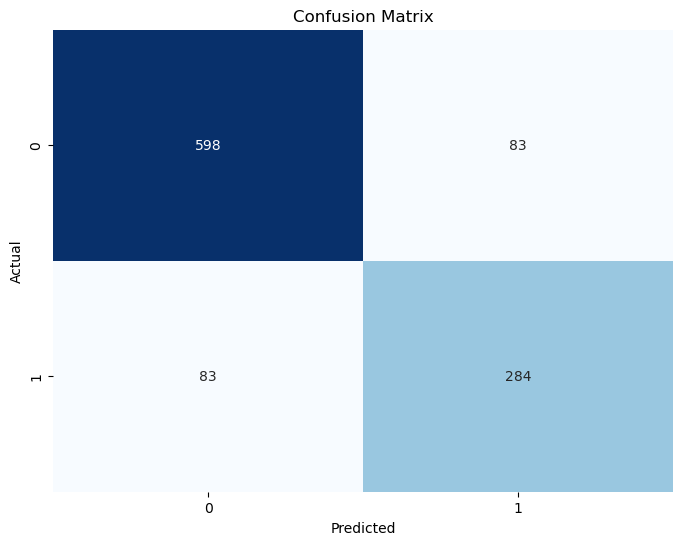

In [35]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

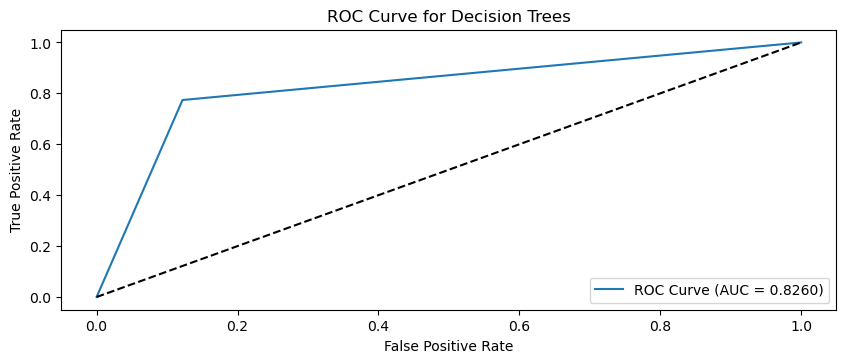

In [36]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Combination of Best Hyperparameters

In [37]:
#max_features="sqrt", min_samples_leaf=10, max_depth=5, criterion="gini"
model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       681
           1       0.78      0.80      0.79       367

    accuracy                           0.85      1048
   macro avg       0.83      0.84      0.84      1048
weighted avg       0.85      0.85      0.85      1048



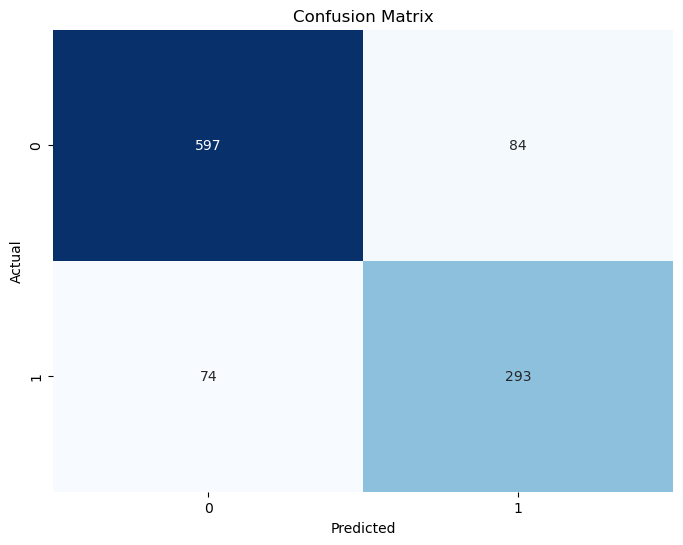

In [38]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

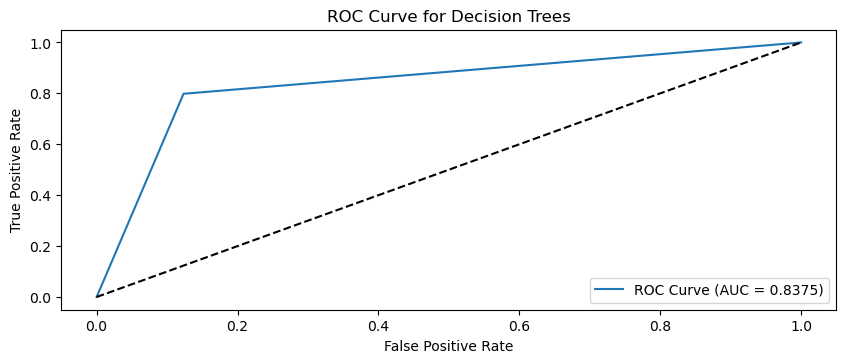

In [39]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

# Feature Selection

In [40]:
df.head(5)

,Unnamed: 0,geo_name,year,votes,vote_share,incumbent,winner,prob_democrat,prob_republican,pid_est,prob_male,prob_female,gender_est,prob_black,prob_white,prob_hispanic,prob_asian,prob_other,race_est,contributor.cfscore,percent_women,percent_white,percent_black,percent_hispanic,percent_asian_american,candidate_count,cpi_prevYear,unemployment_prevYear,pid_est_knn,gender_est_knn,race_est_knn
0,3244,Abilene,1996,3826.0,0.89,1.0,1,0.050000,0.950000,Republican,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,1.020000,0.502459,0.798016,0.080899,0.178764,0.101590,2,152.383333,5.6,1.000000,1.0,2.0
1,4719,Abilene,1996,451.0,0.11,0.0,0,0.573265,0.426735,Unknown,1.0,0.0,Male,0.03,0.97,0.0,0.0,0.0,Caucasian,-0.145909,0.502459,0.798016,0.080899,0.178764,0.101590,2,152.383333,5.6,0.417135,1.0,2.0
2,530,Akron,2003,26967.0,0.71,1.0,1,1.000000,0.000000,Democrat,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,-0.850000,0.520664,0.657211,0.293766,0.014515,0.022447,2,179.866667,5.8,0.000000,1.0,2.0
3,1480,Akron,2003,11171.0,0.29,0.0,0,0.000000,1.000000,Republican,1.0,0.0,Male,0.58,0.41,0.0,0.0,0.0,Black,0.550000,0.520664,0.657211,0.293766,0.014515,0.022447,2,179.866667,5.8,1.000000,1.0,1.0
4,419,Akron,2011,31674.0,0.70,1.0,1,1.000000,0.000000,Democrat,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,-0.362011,0.517043,0.619837,0.313499,0.022048,0.030919,2,218.076167,9.6,0.000000,1.0,2.0


### Best Model with KNN Features

In [41]:
categorical_features = ["incumbent"]
numeric_features = ["candidate_count", "pid_est_knn", "gender_est_knn", "race_est_knn"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [42]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count',
                                                   'pid_est_knn',
                                                   'gender_est_knn',
                                                   'race_est_knn'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [43]:
Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       681
           1       0.78      0.79      0.78       367

    accuracy                           0.85      1048
   macro avg       0.83      0.83      0.83      1048
weighted avg       0.85      0.85      0.85      1048



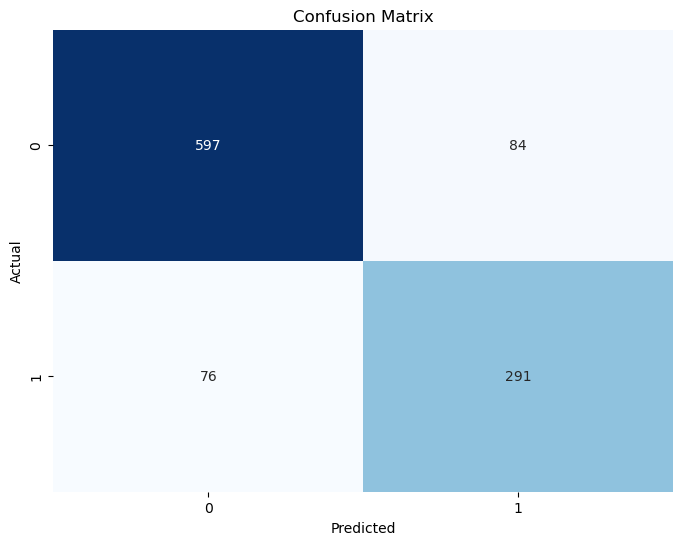

In [44]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

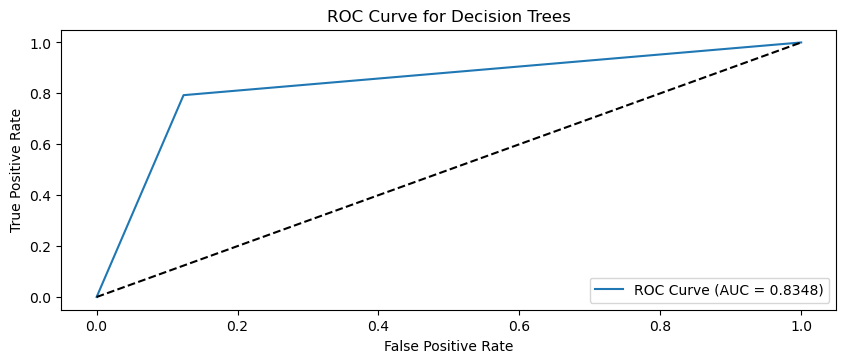

In [45]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Best Model with Numeric Features

In [46]:
categorical_features = ["incumbent"]
numeric_features = ["candidate_count", "prob_democrat", "prob_republican", "prob_male", "prob_female", "prob_black",
                    "prob_white", "prob_hispanic", "prob_asian", "prob_other"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [47]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count',
                                                   'prob_democrat',
                                                   'prob_republican',
                                                   'prob_male', 'prob_female',
                                                   'prob_black', 'prob_white',
                                                   'prob_hispanic',
                                                   'prob_asian',
                                                   'prob_other'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [48]:
Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       681
           1       0.78      0.80      0.79       367

    accuracy                           0.85      1048
   macro avg       0.83      0.84      0.84      1048
weighted avg       0.85      0.85      0.85      1048



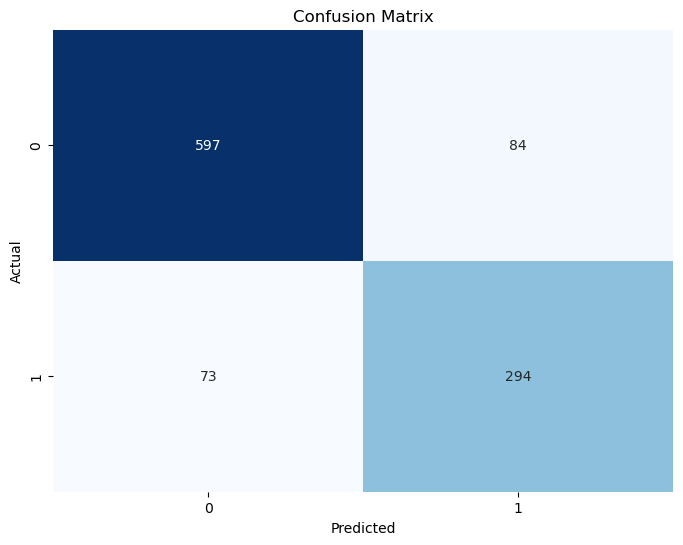

In [49]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

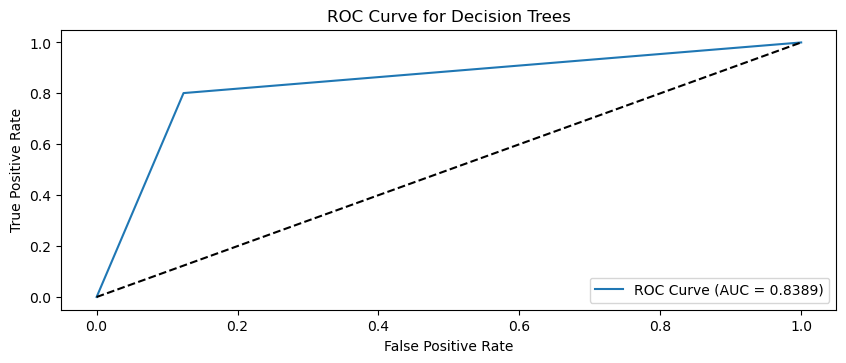

In [50]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Best Model with Contributor Ideology Score

In [51]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "contributor.cfscore"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [52]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['pid_est', 'gender_est',
                                                   'race_est', 'incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count',
                                                   'contributor.cfscore'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [53]:
Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       681
           1       0.78      0.71      0.74       367

    accuracy                           0.83      1048
   macro avg       0.81      0.80      0.81      1048
weighted avg       0.83      0.83      0.83      1048



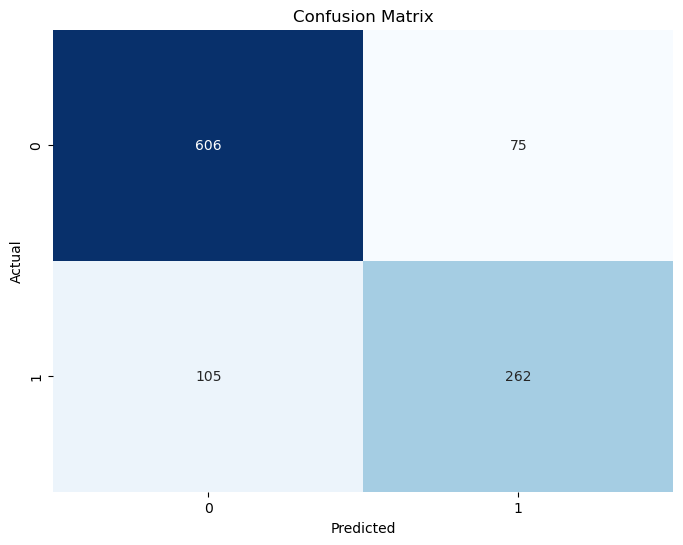

In [54]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

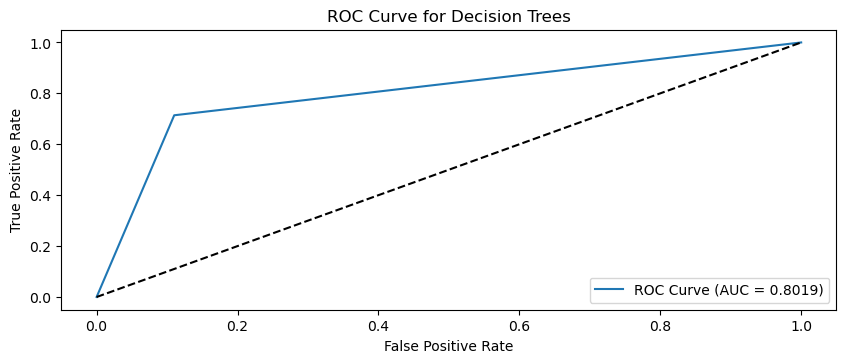

In [55]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Best Model with Population % Gender

In [56]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "percent_women"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [57]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['pid_est', 'gender_est',
                                                   'race_est', 'incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count',
                                                   'percent_women'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [58]:
Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       681
           1       0.78      0.70      0.73       367

    accuracy                           0.82      1048
   macro avg       0.81      0.79      0.80      1048
weighted avg       0.82      0.82      0.82      1048



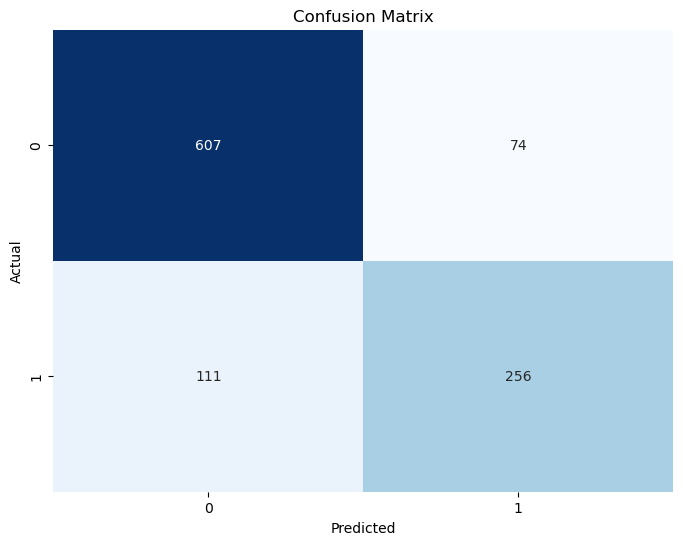

In [59]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

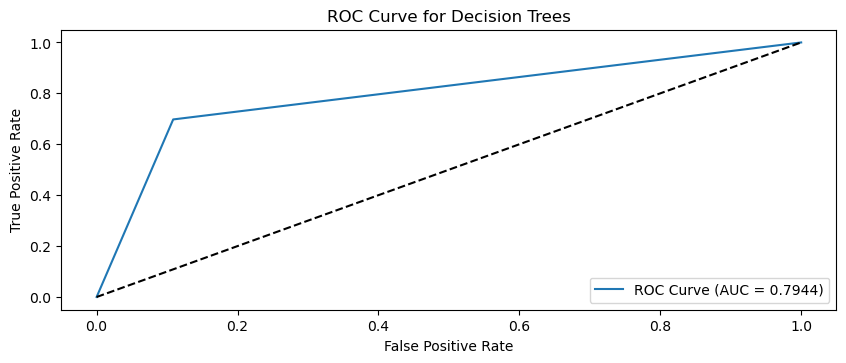

In [60]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Best Model with Population % Race

In [61]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "percent_black", "percent_white",
                    "percent_hispanic", "percent_asian_american"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [62]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['pid_est', 'gender_est',
                                                   'race_est', 'incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count',
                                                   'percent_black',
                                                   'percent_white',
                                                   'percent_hispanic',
                                                   'percent_asian_american'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [63]:
Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       681
           1       0.79      0.76      0.78       367

    accuracy                           0.85      1048
   macro avg       0.83      0.83      0.83      1048
weighted avg       0.85      0.85      0.85      1048



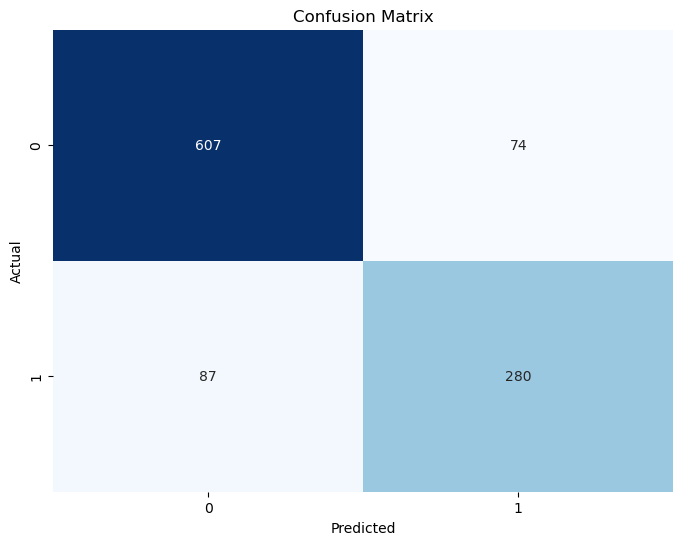

In [64]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

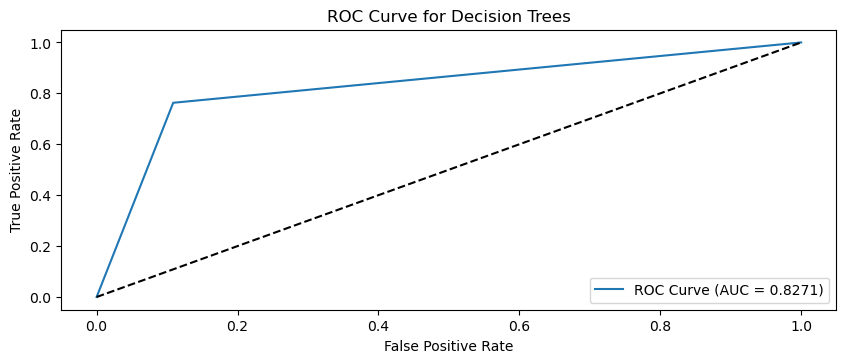

In [65]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Best Model with Prev Year's CPI

In [66]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "cpi_prevYear"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [67]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['pid_est', 'gender_est',
                                                   'race_est', 'incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count',
                                                   'cpi_prevYear'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [68]:
Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       681
           1       0.77      0.77      0.77       367

    accuracy                           0.84      1048
   macro avg       0.82      0.82      0.82      1048
weighted avg       0.84      0.84      0.84      1048



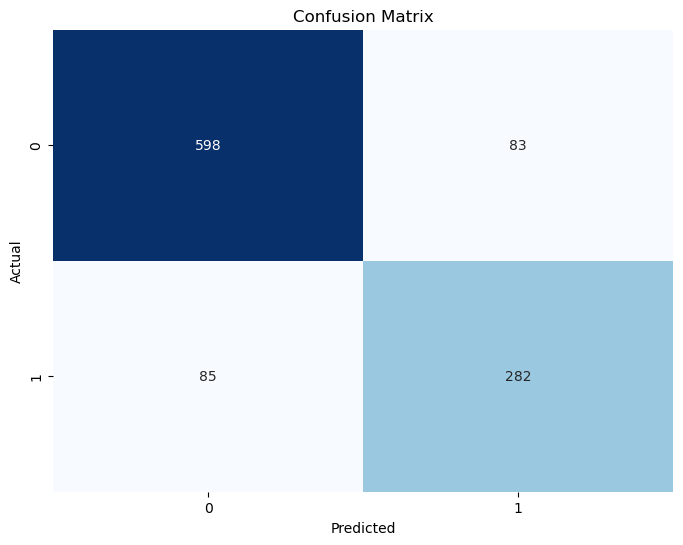

In [69]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

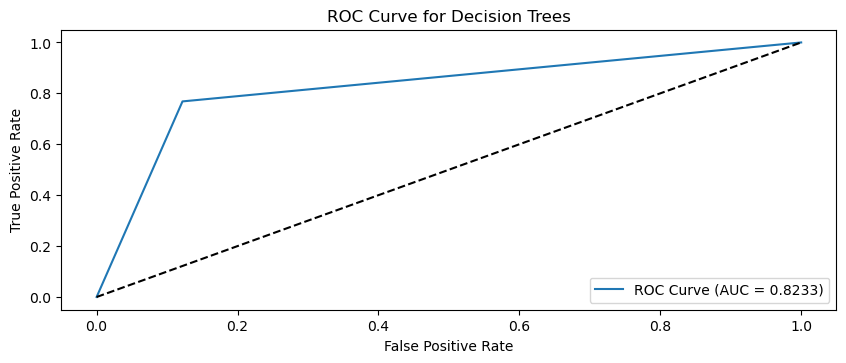

In [70]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

### Best Model with Prev Year's Unemployment

In [71]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "unemployment_prevYear"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [72]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['pid_est', 'gender_est',
                                                   'race_est', 'incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count',
                                                   'unemployment_prevYear'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [73]:
Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       681
           1       0.77      0.77      0.77       367

    accuracy                           0.84      1048
   macro avg       0.82      0.82      0.82      1048
weighted avg       0.84      0.84      0.84      1048



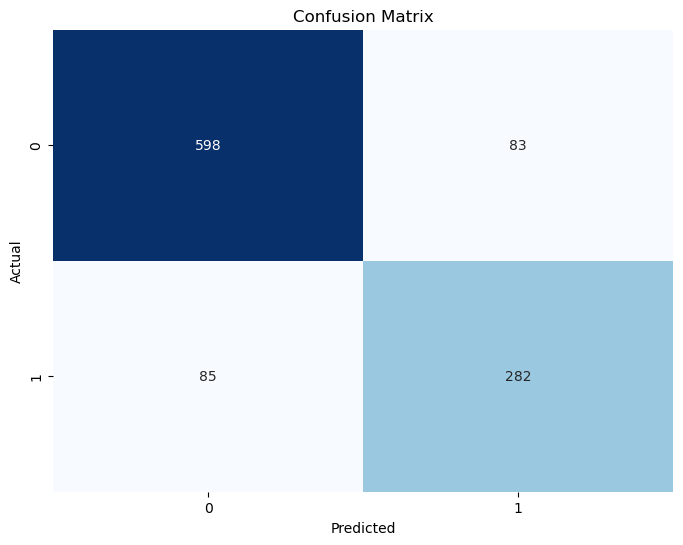

In [74]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

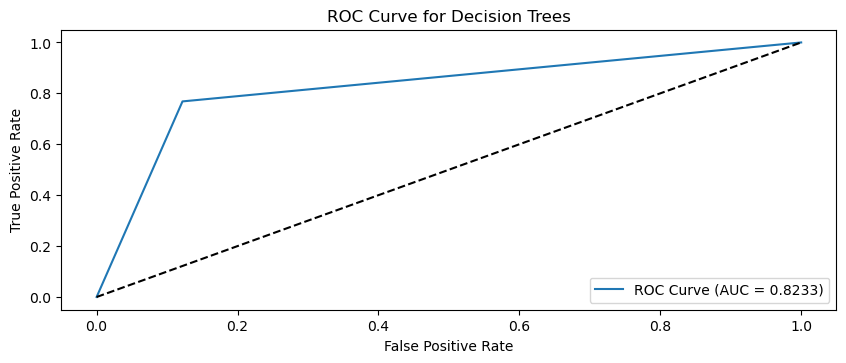

In [75]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')

# Final Decision Tree Model

In [76]:
categorical_features = ["incumbent"]
numeric_features = ["candidate_count", "prob_democrat", "prob_republican", "prob_male", "prob_female", "prob_black",
                    "prob_white", "prob_hispanic", "prob_asian", "prob_other"]
selected_features = categorical_features + numeric_features

X = df[selected_features]
Y = df["winner"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [77]:
ohe = OneHotEncoder()
std = StandardScaler()

ct = make_column_transformer(
    (ohe, categorical_features),
    (std, numeric_features),
    remainder = 'passthrough'
)

model = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, max_depth=5, random_state=42)

pipeline = make_pipeline(ct, model)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['incumbent']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['candidate_count',
                                                   'prob_democrat',
                                                   'prob_republican',
                                                   'prob_male', 'prob_female',
                                                   'prob_black', 'prob_white',
                                                   'prob_hispanic',
                                                   'prob_asian',
                                                   'prob_other'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [78]:
Y_pred = pipeline.predict(X_test)

print("\nTest Set Evaluation:")
print(classification_report(Y_test, Y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       681
           1       0.78      0.80      0.79       367

    accuracy                           0.85      1048
   macro avg       0.83      0.84      0.84      1048
weighted avg       0.85      0.85      0.85      1048



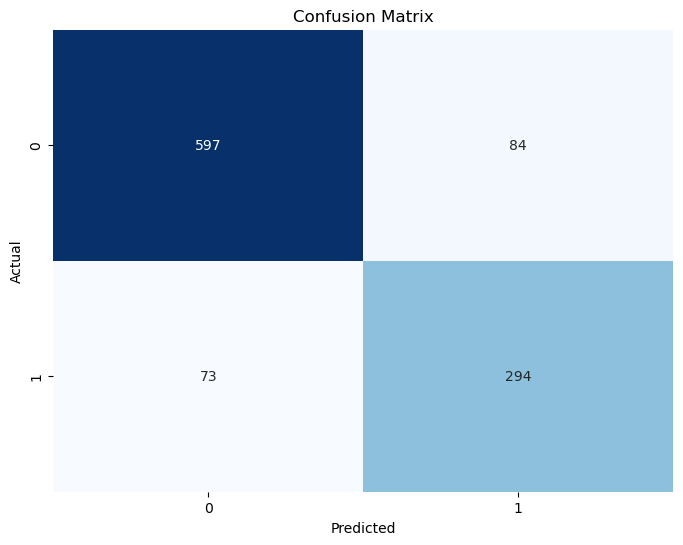

In [79]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

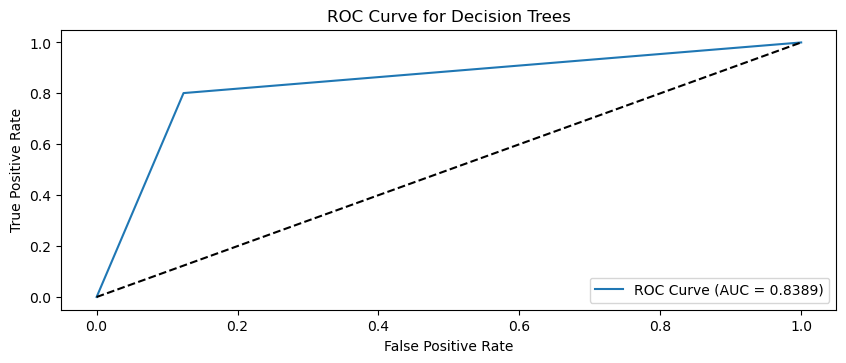

In [80]:
roc_auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend(loc='lower right')